# Error Mitigation Algorithm: For a GHZ State. 

- María Agudo
- Giuseppe Scolamiero
- Delimar Nanín
- Alejandro Rea
- Larry Rivero
- Daniela Salas

Tutors: 
- Manuel Morgado, University of Strasbourg.
- Faisal Alam, University of Illinois Urbana-Champaign.


In [ ]:
pip install qiskit 

In [ ]:
from qiskit import * 

try:
  !pip install pylatexenc
  estilo = 'mpl'
  QuantumCircuit(1).draw(estilo)
except:
  estilo = 'text'
  
from qiskit.visualization import plot_histogram
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from qiskit.visualization import array_to_latex

In [ ]:
qreg = QuantumRegister(3) #3 qubits, we can add them later to a circuit
#complete_meas_cal(a QuantumRegister, a ClassicalRegister or a qubit_list) 
meas_calib, state_lab = complete_meas_cal(qr=qreg, circlabel='mcal')

In [ ]:
state_lab

['000', '001', '010', '011', '100', '101', '110', '111']

In [ ]:
for circuit in meas_calib: #Print each circuit in meas_calibs (2^3 circuits for 3 qubits)
    print('Circuit',circuit.name,'\n')
    print(circuit)
    print()

Circuit mcalcal_000 

       ░ ┌─┐      
q0_0: ─░─┤M├──────
       ░ └╥┘┌─┐   
q0_1: ─░──╫─┤M├───
       ░  ║ └╥┘┌─┐
q0_2: ─░──╫──╫─┤M├
       ░  ║  ║ └╥┘
c0: 3/════╩══╩══╩═
          0  1  2 

Circuit mcalcal_001 

      ┌───┐ ░ ┌─┐      
q0_0: ┤ X ├─░─┤M├──────
      └───┘ ░ └╥┘┌─┐   
q0_1: ──────░──╫─┤M├───
            ░  ║ └╥┘┌─┐
q0_2: ──────░──╫──╫─┤M├
            ░  ║  ║ └╥┘
c0: 3/═════════╩══╩══╩═
               0  1  2 

Circuit mcalcal_010 

            ░ ┌─┐      
q0_0: ──────░─┤M├──────
      ┌───┐ ░ └╥┘┌─┐   
q0_1: ┤ X ├─░──╫─┤M├───
      └───┘ ░  ║ └╥┘┌─┐
q0_2: ──────░──╫──╫─┤M├
            ░  ║  ║ └╥┘
c0: 3/═════════╩══╩══╩═
               0  1  2 

Circuit mcalcal_011 

      ┌───┐ ░ ┌─┐      
q0_0: ┤ X ├─░─┤M├──────
      ├───┤ ░ └╥┘┌─┐   
q0_1: ┤ X ├─░──╫─┤M├───
      └───┘ ░  ║ └╥┘┌─┐
q0_2: ──────░──╫──╫─┤M├
            ░  ║  ║ └╥┘
c0: 3/═════════╩══╩══╩═
               0  1  2 

Circuit mcalcal_100 

            ░ ┌─┐      
q0_0: ──────░─┤M├──────
            ░ └╥┘┌─

In [ ]:
aer_sim = Aer.get_backend('aer_simulator') #We choose aer_simulator as backend.

#We run the circuit without noise
t_qcirc = transpile(meas_calib, aer_sim) 
#transpile(circuits to transpile, backend) transpile: run all the circuits.

qobject = assemble(t_qcirc, shots=10000) 
#assemble: Gathers a circuit list in a Qobj. 
result_calib = aer_sim.run(qobject, shots=10000).result()
#aer_sim.run runs the simulations, .result() gives us the result for the calibration in cal_results.

In [ ]:
fitter_meas = CompleteMeasFitter(result_calib, state_lab, circlabel='mcal') #Creates the calibration matrix M.
array_to_latex(fitter_meas.cal_matrix) #In this case w/o noise we have the identity matrix.

<IPython.core.display.Latex object>

In [ ]:
"""Here we defined the noise function """

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

def get_noise(p):

    error_meas = pauli_error([('Y', p/2), ('X', p/2), ('I', 1 - p)]) 

    noise_model = NoiseModel() 

    #we add the error_meas to the noise_model.
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements.
        
    return noise_model

In [ ]:
#We create a list of values to use and round them to 3 decimals.
values_list = np.round(np.linspace(0.05, 0.50, 50), decimals=3)
values_list

array([0.05 , 0.059, 0.068, 0.078, 0.087, 0.096, 0.105, 0.114, 0.123,
       0.133, 0.142, 0.151, 0.16 , 0.169, 0.179, 0.188, 0.197, 0.206,
       0.215, 0.224, 0.234, 0.243, 0.252, 0.261, 0.27 , 0.28 , 0.289,
       0.298, 0.307, 0.316, 0.326, 0.335, 0.344, 0.353, 0.362, 0.371,
       0.381, 0.39 , 0.399, 0.408, 0.417, 0.427, 0.436, 0.445, 0.454,
       0.463, 0.472, 0.482, 0.491, 0.5  ])

In [ ]:
#two empty list for the loop afterwards
noise_values = []
fidelity_values = []

In [ ]:
percentage = 0.1
noise_model = get_noise(percentage) #We add the noise, 10% probability.

In [ ]:
t_qcirc = transpile(meas_calib, aer_sim)
qobject = assemble(t_qcirc, shots=10000)
result_calib = aer_sim.run(qobject, noise_model=noise_model, shots=10000).result()

fitter_meas = CompleteMeasFitter(result_calib, state_lab, circlabel='mcal')
array_to_latex(fitter_meas.cal_matrix) #This is the calibration matrix M 

<IPython.core.display.Latex object>

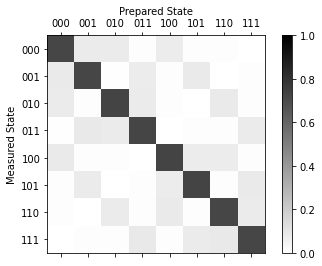

In [ ]:
fitter_meas.plot_calibration()

The filter works fine, we apply it to the circuit with $GHZ$ state:

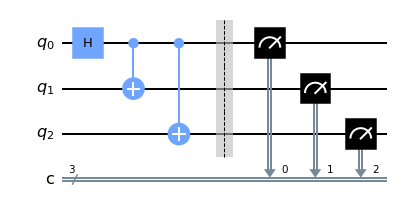

In [ ]:
#GZH circuit
qc = QuantumCircuit(3,3) 
qc.h(0) #Hadamard gate transforms |0> to |+>
qc.cx(0,1) #CNOT gates
qc.cx(0,2)
qc.barrier()
qc.measure(0,0)
qc.measure(1,1)
qc.measure(2,2)
qc.draw(estilo)

In [ ]:
t_qc = transpile(qc, aer_sim)
qobject = assemble(t_qc, shots=10000)
results = aer_sim.run(qobject, noise_model=noise_model, shots=10000).result()

In [ ]:
#We get a sample of the results
noisy_counts = results.get_counts()
print(noisy_counts)

{'010': 461, '101': 460, '000': 3657, '111': 3617, '011': 459, '110': 476, '100': 428, '001': 442}


In [ ]:
# Get the filter object
meas_filter = fitter_meas.filter

# Results with mitigation
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts()

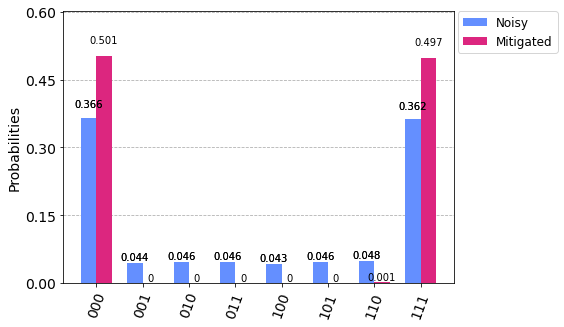

In [ ]:
#Plot the results, mitigaded and non-mitigated (noisy)
noisy_counts = results.get_counts()
plot_histogram([noisy_counts, mitigated_counts], legend=['Noisy', 'Mitigated'])

In [ ]:
# What is the measurement fidelity?
print("Average Measurement Fidelity: %f" % fitter_meas.readout_fidelity())


Average Measurement Fidelity: 0.727838


## Loop 50 times for the noise function
We loop the function 50 times increasing the noise probability with 50 values between 5 and 50, to calculate the fidelity and plot the data

In [ ]:
import numpy as np

In [ ]:
for value in values_list:

#---------------
  percentage = value #we use the list defined previously
  noise_model = get_noise(percentage) #Add the noise.
#---------------

#---------------
  t_qcirc = transpile(meas_calib, aer_sim)
  qobject = assemble(t_qcirc, shots=10000)
  result_calib = aer_sim.run(qobject, noise_model=noise_model, shots=10000).result()

  fitter_meas = CompleteMeasFitter(result_calib, state_lab, circlabel='mcal')
#--------------

#--------------
  qc = QuantumCircuit(3,3) 
  qc.h(0)
  qc.cx(0,1) 
  qc.cx(0,2)
  qc.barrier()
  qc.measure(0,0)
  qc.measure(1,1)
  qc.measure(2,2)
#-------------

#-------------
  t_qc = transpile(qc, aer_sim)
  qobject = assemble(t_qc, shots=10000)
  results = aer_sim.run(qobject, noise_model=noise_model, shots=10000).result()
#-------------

#-------------
# Get the filter object
  meas_filter = fitter_meas.filter

# Results with mitigation
  mitigated_results = meas_filter.apply(results)
  mitigated_counts = mitigated_results.get_counts()
#-------------

#-------------
  final_fidelity = fitter_meas.readout_fidelity() #average fidelity

  noise_values.append(percentage)
  fidelity_values.append(final_fidelity)


In [ ]:
print(f"Noise values: {noise_values}")
print('\n')
print(f"Fidelity values: {fidelity_values}")

Noise values: [0.05, 0.059, 0.068, 0.078, 0.087, 0.096, 0.105, 0.114, 0.123, 0.133, 0.142, 0.151, 0.16, 0.169, 0.179, 0.188, 0.197, 0.206, 0.215, 0.224, 0.234, 0.243, 0.252, 0.261, 0.27, 0.28, 0.289, 0.298, 0.307, 0.316, 0.326, 0.335, 0.344, 0.353, 0.362, 0.371, 0.381, 0.39, 0.399, 0.408, 0.417, 0.427, 0.436, 0.445, 0.454, 0.463, 0.472, 0.482, 0.491, 0.5]


Fidelity values: [0.8565750000000001, 0.8332124999999999, 0.8112625, 0.784825, 0.7615375, 0.7382875, 0.7160124999999999, 0.6939625, 0.6769125, 0.6511375, 0.6339374999999999, 0.611175, 0.59295, 0.574225, 0.557375, 0.5375749999999999, 0.5145875, 0.5023249999999999, 0.48448749999999996, 0.4664125, 0.449175, 0.4340125, 0.41605, 0.404525, 0.38708750000000003, 0.37411249999999996, 0.3617, 0.34521250000000003, 0.3349, 0.3191625, 0.3093875, 0.294625, 0.2816875, 0.2716375, 0.2613, 0.24985000000000002, 0.2382, 0.2252375, 0.21810000000000002, 0.20571250000000002, 0.1982375, 0.186525, 0.1800625, 0.17065, 0.1643125, 0.15288749999999998, 0.147675

In [ ]:
import scipy.optimize as opt

final_noise = np.array(noise_values) * 100 #to get the percentage in the correct format 0-100%
fidelity_final = np.round(fidelity_values, decimals = 3) #rounding up the values to the format 0.000 (3 decimals)

x = final_noise
y = fidelity_final
optimized = opt.curve_fit(lambda t,a,b: a*np.exp(b*t),  x,  y,  p0=(0.80, -0.1)) #curve fitting
#([a, b])

In [ ]:
#We have a bunch of arrays, from the first one we have [a, b]
a = optimized[0][0]
b = optimized[0][1]
print(a,b)

1.0802313292091368 -0.03896927727165702


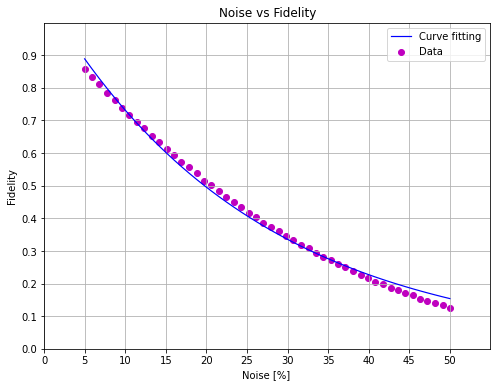

In [ ]:
#Plotting the datta as a scatter plot
plt.figure(figsize=(8,6))

plt.scatter(final_noise, fidelity_values, color='m', marker='o', label='Data')
plt.grid()

plt.xlabel('Noise [%] ')
plt.ylabel('Fidelity')
plt.xlim(0,55)
plt.ylim(0,1)

plt.xticks(np.arange(0, len(final_noise)+1, 5))
plt.yticks(np.arange(0, 1, 0.1))

x_fitted = final_noise
y_fitted = a*np.exp(b*x)
plt.plot(x_fitted, y_fitted, label='Curve fitting', color='blue', lw=1.2)

plt.title('Noise vs Fidelity')
plt.legend()


plt.show()